In [16]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, LearningCurveDisplay, learning_curve, ValidationCurveDisplay, validation_curve
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    fbeta_score,
    classification_report,
    make_scorer
)


from utils import get_data, get_df_details, plot_distrb, make_confusion_matrix

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [17]:
X, y, metadata, variables = get_data('dry_bean_dataset')

In [18]:
# This is an imbalanced dataset - use F-beta metric for evaluation
# https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

y.value_counts(normalize=True)

Class   
DERMASON    0.260525
SIRA        0.193667
SEKER       0.148924
HOROZ       0.141650
CALI        0.119756
BARBUNYA    0.097127
BOMBAY      0.038351
Name: proportion, dtype: float64

In [19]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [20]:
idx = variables['type'].isin(['Integer', 'Continuous'])
num_cols = variables.loc[idx, 'name']
num_cols = num_cols.loc[~num_cols.isin(y.columns.tolist())]
num_cols

0                Area
1           Perimeter
2     MajorAxisLength
3     MinorAxisLength
4         AspectRatio
5        Eccentricity
6          ConvexArea
7       EquivDiameter
8              Extent
9            Solidity
10          Roundness
11        Compactness
12       ShapeFactor1
13       ShapeFactor2
14       ShapeFactor3
15       ShapeFactor4
Name: name, dtype: object

In [21]:
idx = variables['type'].isin(['Binary', 'Categorical'])
cat_cols = variables.loc[idx, 'name']
cat_cols = cat_cols.loc[~cat_cols.isin(y.columns)]
cat_cols

Series([], Name: name, dtype: object)

# Train NN

In [28]:

RANDOM_STATE = 42
N_FOLDS = 5
N_JOBS = -1
SCORING = 'accuracy'
VERBOSE = 4


# Use minmax scaler for simplicity, scalability, avoids assumption of distribution and there are no outliers in data
num_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])
# cat_pipeline = Pipeline(steps=[
#     ('one-hot', OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse=False))
# ])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    # ('cat_pipeline', cat_pipeline, cat_cols)
    ],
    remainder='drop',
    n_jobs=N_JOBS)

clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=5000, early_stopping=True, n_iter_no_change=10, learning_rate='adaptive')
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])



## Tune the NN

In [33]:
cv_scores = []

grid_params = {
        'activation': {'model__activation': ['identity', 'logistic', 'tanh', 'relu']}, 
        'solver': {'model__solver':['lbfgs', 'sgd', 'adam']},
        'alpha': {'model__alpha': [0.001, 0.10, 0.3, 1, 3, 5, 10]},
        'hidden_layer_sizes' : {'model__hidden_layer_sizes': [(10,), (10, 10), (100, ), (50, 50), (100, 100)]}
    }
for key, grid_param in grid_params.items():
    print('------------------', key, '------------------')
    
    gs = GridSearchCV(clf_pipeline, grid_param, 
                      cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True)
    gs.fit(X_train, y_train.values.ravel())

    cv_scores.append(pd.DataFrame({'param': [key]*len(gs.cv_results_['mean_test_score']),
                                   'value': gs.cv_results_[f'param_{list(grid_param.keys())[0]}'],
                                   'mean_score': gs.cv_results_['mean_test_score']}))

cv_scores = pd.concat(cv_scores)

------------------ activation ------------------
Fitting 5 folds for each of 4 candidates, totalling 20 fits
------------------ solver ------------------
Fitting 5 folds for each of 3 candidates, totalling 15 fits
------------------ alpha ------------------
Fitting 5 folds for each of 7 candidates, totalling 35 fits
------------------ hidden_layer_sizes ------------------
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [35]:
cv_scores.loc[cv_scores['param'] == 'hidden_layer_sizes', 'value'] = \
cv_scores.loc[cv_scores['param'] == 'hidden_layer_sizes', 'value'].astype(str)

c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


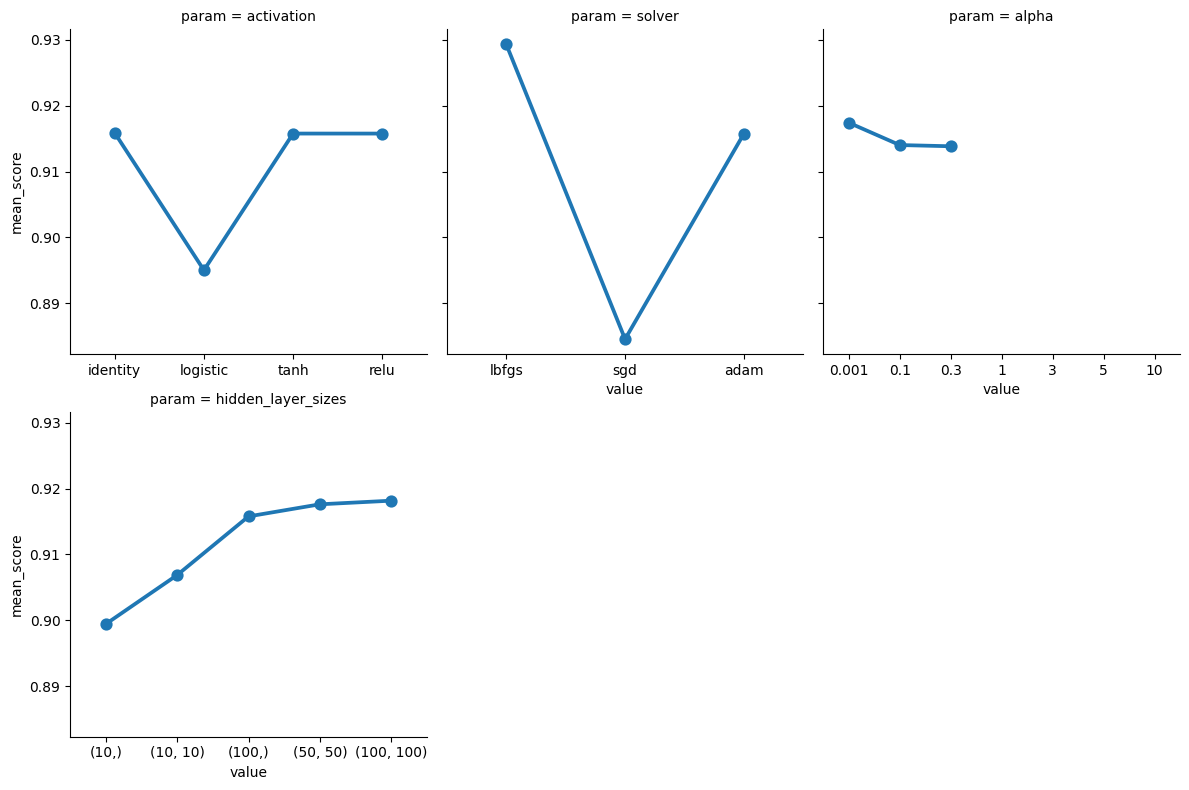

In [36]:

sns.FacetGrid(cv_scores, col='param', col_wrap=3, height=4, sharex=False).map(sns.pointplot, 'value', 'mean_score')

In [37]:
grid_params = {
        'model__activation': ['identity', 'tanh', 'relu'], 
        'model__solver':['lbfgs', 'adam'],
        'model__alpha': [0.001, 0.10, 0.3],
        'model__hidden_layer_sizes': [(75,), (100, ), (150,), (50, 50)]
    }

gs = GridSearchCV(clf_pipeline, grid_params, 
                    cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True)
gs.fit(X_train, y_train.values.ravel())

print("Best Score of train set: "+str(gs.best_score_))
print("Best parameter set: "+str(gs.best_params_))
print("Test Score: "+str(gs.score(X_test,y_test)))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
gs.best_estimator_['model']

In [ ]:
import joblib
joblib.dump(value=gs, filename='nn_dry_bean_ppl.pkl', compress=True)
joblib.dump(value=gs.best_estimator_, filename='nn_dry_bean_best.pkl', compress=True)

In [ ]:
from sklearn.model_selection import ValidationCurveDisplay, validation_curve


param_name, param_range = "alpha", np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
train_scores, test_scores = validation_curve(
     gs.best_estimator_['model'], X, y, param_name=param_name, param_range=param_range, cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE
 )
display = ValidationCurveDisplay(
     param_name=param_name, param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="Score"
)
display.plot()
plt.show()

In [ ]:
gs.cv_results_.keys()

# gs.cv_results_['mean_test_score']

# dict_keys(['mean_fit_time', 'std_fit_time', 
# 'mean_score_time', 'std_score_time', 
# 'param_model__max_depth', 'params', 
# 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 
# 'mean_test_score', 'std_test_score', 'rank_test_score', 
# 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 
# 'mean_train_score', 'std_train_score'])


In [ ]:

# Plot learning curve of the best model from grid search
train_size_abs, train_scores, test_scores = \
    learning_curve(gs.best_estimator_, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=N_FOLDS, n_jobs=N_JOBS, scoring=SCORING, verbose=VERBOSE)

In [ ]:
plot_df = pd.DataFrame({'train_size_abs': train_size_abs, 
                        'mean_train_scores': np.mean(train_scores, axis=1), 
                        'mean_test_scores': np.mean(test_scores, axis=1)})
plot_df = plot_df.melt(id_vars='train_size_abs', value_vars=['mean_train_scores', 'mean_test_scores'])
sns.pointplot(plot_df, x='train_size_abs',y ='value', hue='variable')

In [ ]:

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": N_FOLDS,
    "score_type": "both",
    "n_jobs": N_JOBS,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": SCORING,
}

for ax_idx, estimator in enumerate([clf_pipeline]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

In [ ]:
# Get the score of the best model on test

# gs.best_estimator_ is the best model found by GridSearchCV
y_test_predictions = gs.predict(X_test)
# Generate confusion matrix for the predictions from the best model
conf_matrix = confusion_matrix(y_test, y_test_predictions)

make_confusion_matrix(conf_matrix, group_names=['True Neg','False Pos','False Neg','True Pos'], categories=['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'], cmap='Blues')

In [ ]:

scores = {'accuracy_score':accuracy_score(y_test, y_test_predictions),
          'precision_score':precision_score(y_test, y_test_predictions),
          'recall_score':recall_score(y_test, y_test_predictions),
          'f2_score':fbeta_score(y_test, y_test_predictions, beta=2)
}

print(scores)


In [ ]:

# target_names=target_names
print(classification_report(y_test, y_test_predictions))


In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(gs, X_test, y_test, )
plt.show()

In [ ]:
# plot precison recall curve
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_recall_curve,
                              PrecisionRecallDisplay)

precision, recall, _ = precision_recall_curve(y_test, y_test_predictions)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()